In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

import sklearn.linear_model as linear_models
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, TimeSeriesSplit

import xgboost as xgb
import sklearn.model_selection as ms

In [3]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df)
df = df.sort_index(ascending=False)
df.dropna(inplace=True)

# Choose time series cross-validation method
### TimeSeriesSplit vs BlockTimeSeriesSplit

In [48]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

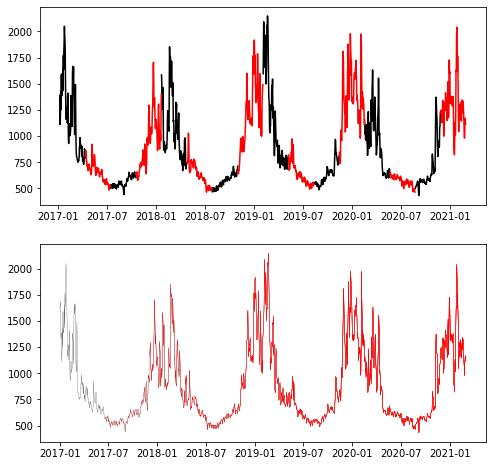

In [66]:
#visualize training/test setse
plt.figure(figsize=(8,8))
n_splits=2
tscv = BlockingTimeSeriesSplit(n_splits=n_splits)
for test_index, train_index in tscv.split(df.index):
    X_train, X_test = df.index[train_index], df.index[test_index]
    Y_train, Y_test = df.iloc[train_index]['SoCal_TOTAL'], df.iloc[test_index]['SoCal_TOTAL']
    plt.subplot(2,1,1), plt.title('Blocking time series split')
    plt.plot(X_train, Y_train, 'k')
    plt.plot(X_test, Y_test, 'r')

tscv = TimeSeriesSplit(n_splits=n_splits)
for test_index, train_index in tscv.split(df.index):
    X_train, X_test = df.index[train_index], df.index[test_index]
    Y_train, Y_test = df.iloc[train_index]['SoCal_TOTAL'], df.iloc[test_index]['SoCal_TOTAL']
    plt.subplot(2,1,2), plt.title('Time series split')
    plt.plot(X_train, Y_train, 'k', linewidth=.2)
    plt.plot(X_test, Y_test, 'r', linewidth=.2)
    

In [4]:
region = 'SoCal' # can be SD or SoCal
target = df[region + '_TOTAL']

predictor_dict = \
{'set_1': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_2': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', 
               'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
               'Sat','Sun','Holiday'],
'set_3': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_4': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'day_of_year_sine', 'day_of_year_cosine',
               'Sat','Sun','Holiday'],
'set_5': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD', region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', region + '_t-2_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7', region + '_t-2_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
'set_6': [region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',
                 region + '_CDD',region + '_t-1_CDD',
                 region+'_HDD_7', region + '_t-1_HDD_7',
               'month_sine', 'month_cosine',
               'Sat','Sun','Holiday'],
}

In [68]:
tscv = TimeSeriesSplit(n_splits=) # cross validation split metric
best_params = {} # dictionary of best parameters 
evaluation_df = pd.DataFrame() # dataframe of evaluation metrics
for key, value in predictor_dict.items(): 
    
    xgb_model = xgb.XGBRegressor()
    predictors = df[value]
    # hyperparameter tuning for XGBoost 
    params = {
            'learning_rate'  : [0.10, 0.20, 0.30 ], #increasing value decreases computation time but possibly accuracy
            'min_child_weight': [3, 5, 8, 10], # larger = more conservative
            'gamma': [0.5, 1, 1.5, 2, 5], # loss reduction threshold to make a split. larger =  more conservative
            'colsample_bytree': [0.6, 0.75, 0.9], # %data to sample per tree. Smaller proportion of data = reduce overfitting
            'max_depth': [3, 4, 5, 6, 7] # % max depth of each tree. Shallower tree depth = reduce overfitting
            }

    xgb_grid = ms.GridSearchCV(xgb_model, param_grid=params, 
                             scoring='neg_mean_absolute_error', verbose=3 ) #default is 5-fold CV
    xgb_grid.fit(predictors, target)
    
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'explained_variance']
    xgb_scores = cross_validate(xgb_grid.best_estimator_, predictors, target, cv=tscv, scoring = scoring)
    
    analyses = dict(zip(scoring, [np.mean(xgb_scores['test_' + metric]) for metric in scoring]))
    analyses_df = pd.DataFrame.from_dict(analyses, orient='index').transpose()
    analyses_df.index = [key]
    evaluation_df = pd.concat([evaluation_df, analyses_df])
    best_params.update({key: xgb_grid.best_params_})

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-34.653, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.270, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.522, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-44.463, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-39.062, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-34.832, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-50.007, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-46.601, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.637, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.983, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-35.110, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.146, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.565, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-46.718, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.136, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-42.458, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-35.460, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.612, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.906, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.323, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.975, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.463, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-37.292, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-36.561, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.859, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.938, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.852, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-37.668, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.944, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-50.070, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.707, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-45.193, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-37.390, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.609, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.026, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.703, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.216, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-46.287, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-35.555, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-38.858, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.844, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.568, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-43.770, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-38.465, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.278, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.898, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-49.049, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-37.330, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.113, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.261, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.508, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-42.642, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.218, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.231, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.439, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-42.071, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.797, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.331, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.271, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.923, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-42.998, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-35.231, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-38.557, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.601, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.829, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-43.607, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.588, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-51.607, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-56.087, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.919, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.473, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-36.585, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.959, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.402, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-46.008, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.534, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.659, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.270, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.522, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-44.463, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-39.062, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-34.832, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-46.601, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.637, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.983, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-35.110, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.147, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.357, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-46.718, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.136, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-42.470, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-35.478, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.612, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.906, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.050, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.975, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.463, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-37.292, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-36.689, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.860, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.000, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-44.063, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-37.668, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.944, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-50.070, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.707, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-45.193, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-44.980, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-37.390, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.285, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.844, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.702, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-54.535, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.975, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-35.555, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-37.863, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.677, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-50.538, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-43.770, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-38.465, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.278, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.898, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-42.787, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-37.330, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.263, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.508, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-42.806, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-36.465, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.218, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.231, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.439, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-36.638, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.331, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.598, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.406, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-42.997, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-38.625, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.638, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.767, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-43.768, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.654, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-37.332, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.866, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-56.087, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.919, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.473, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-36.512, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.929, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.402, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-46.063, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.534, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.754, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-44.463, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-39.062, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-34.832, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-50.007, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.983, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-35.110, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.147, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.807, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.501, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-42.637, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-35.476, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.243, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-48.256, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.647, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.463, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.151, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-49.548, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-48.888, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-42.861, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-35.188, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-37.466, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.750, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.485, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.639, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-52.074, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-53.168, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-43.859, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-35.784, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-35.549, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.168, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.419, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-35.492, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-40.444, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-53.092, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-51.475, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-46.147, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-35.234, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-39.786, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-53.790, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.057, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-44.219, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.841, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-34.949, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-47.175, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.407, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-51.918, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-43.111, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-34.438, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-35.591, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.926, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-52.159, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-43.307, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.228, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-34.131, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-47.179, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.273, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-43.081, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-35.082, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-36.890, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-36.862, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.372, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-51.456, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-43.889, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-34.465, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.867, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-48.817, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-50.997, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-44.674, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-34.817, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.490, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-37.860, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.678, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-52.086, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-43.895, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.884, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.121, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.263, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.679, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-51.093, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-34.903, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.970, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.634, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.909, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.302, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-34.435, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.333, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-47.476, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-51.048, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-43.284, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-35.284, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-35.269, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-49.068, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-50.657, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.149, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.698, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-37.860, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-47.771, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.552, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-42.226, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-36.261, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-49.732, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.149, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-45.242, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-37.690, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-38.054, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-49.704, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-53.639, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.803, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-33.210, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.195, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-40.442, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.996, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.486, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-45.709, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.646, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.090, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-46.969, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.057, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-44.219, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.818, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-36.158, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.407, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-51.918, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-43.111, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-34.141, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.926, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-52.159, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-43.307, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.228, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-36.790, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-36.921, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-47.179, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.091, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-43.081, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.962, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-42.857, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.511, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-36.862, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.373, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.006, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-43.471, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-35.302, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.867, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-48.817, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.077, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-43.997, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.380, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-37.860, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.801, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.884, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.121, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.263, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.679, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-51.093, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-34.903, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.970, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.631, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.909, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.302, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-35.109, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.148, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-47.475, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-51.048, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-43.284, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-35.269, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-49.068, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-50.657, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.149, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-35.255, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.574, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-37.865, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-47.771, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.552, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-42.226, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-49.732, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.149, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-45.242, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-37.690, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-36.710, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-49.982, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-53.639, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.803, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-33.210, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-38.183, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.944, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.501, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-45.571, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-34.725, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-37.279, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-46.969, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.057, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-44.219, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.841, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-34.898, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.407, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-51.840, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-43.152, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-34.438, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-35.537, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-34.141, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.926, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-52.159, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-43.307, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.228, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-47.179, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.131, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-43.082, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-35.082, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-36.890, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.589, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-51.357, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-43.479, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-34.375, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-36.864, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-50.997, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-44.674, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-34.817, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-37.282, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-49.382, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-52.248, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-43.895, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-33.785, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-38.446, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-50.997, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.137, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-43.649, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-39.306, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-34.678, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-48.629, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.504, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.356, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.588, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-35.661, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-46.513, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-45.791, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.598, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-42.665, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-34.801, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-35.101, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.537, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-46.539, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-51.414, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.564, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.725, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-35.324, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-38.472, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-48.004, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.327, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.131, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-43.784, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-37.427, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-35.583, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.403, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-52.808, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-44.272, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-36.626, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-36.136, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-47.761, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-52.825, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.981, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-45.118, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-35.554, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-38.774, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-48.947, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-49.579, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-42.944, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-38.282, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-35.098, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-45.884, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.721, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.012, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.993, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-35.474, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-45.097, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.549, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.063, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.675, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-35.097, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5,

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.309, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-34.621, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.020, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.123, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.569, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-44.120, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-34.687, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-37.261, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-48.649, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.727, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-35.873, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.865, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-48.521, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-52.842, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-46.338, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.970, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.674, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.210, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-52.419, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-46.813, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-34.633, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.503, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.137, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-43.649, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-39.306, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-35.734, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-34.704, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-46.011, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.504, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.356, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.511, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-35.073, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.666, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-45.825, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.523, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-52.208, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-44.376, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.682, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.537, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-46.539, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-48.186, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.143, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-44.054, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-35.324, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-38.472, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-49.057, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.838, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-43.784, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-37.427, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-35.583, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-47.876, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.687, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.214, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-36.626, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-36.136, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-36.353, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-49.836, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.694, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-45.436, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-35.328, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.471, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-49.579, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-42.944, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-38.543, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-35.098, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-45.832, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.721, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.120, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.993, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-35.474, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.333, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.549, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.060, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.675, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-35.097, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.360, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.310, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-34.621, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.020, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.123, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.585, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-44.312, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-34.599, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-37.261, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-48.649, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.628, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-35.873, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.865, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-48.521, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-52.842, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-47.429, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.972, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.675, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.491, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-52.340, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.908, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-34.633, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.503, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.137, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-43.649, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-34.704, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-46.011, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.504, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.356, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.588, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.506, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-45.825, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.242, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-42.665, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.328, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-46.539, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-51.414, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.549, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.725, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-36.591, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-48.004, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.332, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.131, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-35.078, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-37.563, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-52.808, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-46.303, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-36.809, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-36.206, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-47.510, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-44.973, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-34.912, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-36.684, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-47.509, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-51.058, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-47.198, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-34.880, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-36.594, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-50.561, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-52.086, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 11.6min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.233, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.614, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.160, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-47.418, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.879, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.086, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.237, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.406, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-34.650, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.606, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.147, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.852, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.995, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-33.605, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.599, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.767, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.500, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.847, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.759, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-34.066, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.681, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.372, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.740, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.223, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.503, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.662, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.668, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.686, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.584, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-41.686, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-35.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-35.033, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-39.660, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.036, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-55.299, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.291, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.276, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-34.990, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-41.735, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.583, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-55.087, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-46.331, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-38.250, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.150, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.428, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.567, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-44.184, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-35.521, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.054, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.309, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.518, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-34.904, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.005, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.350, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-52.398, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.483, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-35.568, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-39.234, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.437, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-53.377, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.018, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.782, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.172, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.621, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-44.582, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-34.218, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.566, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.382, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.642, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.322, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.517, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.198, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.818, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-44.294, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-36.863, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-40.339, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.160, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-47.418, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.879, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.086, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.437, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.273, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.237, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.406, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-34.650, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.606, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-51.220, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.832, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.996, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-33.605, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.084, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.500, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.553, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.759, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-34.066, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.373, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.740, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.223, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.503, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.662, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.668, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.686, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.584, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-41.686, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-35.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-39.660, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.036, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-55.167, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.625, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-35.603, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-34.990, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-41.776, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.564, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-55.480, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.959, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-38.250, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.150, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.428, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.567, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-44.708, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, ma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.054, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.309, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.518, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.441, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.634, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.005, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.350, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-52.398, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.483, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.387, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-39.766, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.437, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-53.378, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.018, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-40.023, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.194, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.165, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-44.525, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-34.218, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.566, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.381, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.642, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.322, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.517, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.952, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.791, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-44.253, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-37.012, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-40.387, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.160, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-47.418, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-38.879, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.086, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.437, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.396, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-34.650, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.438, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.147, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.308, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.948, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-33.690, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.432, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.770, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-50.176, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.759, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-34.066, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.264, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-47.467, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-51.139, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.142, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.385, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-39.527, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.762, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.185, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-35.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-36.405, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.330, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-52.765, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-43.628, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-38.462, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-51.049, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-53.354, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.544, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-34.866, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-51.468, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.268, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-47.217, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-34.650, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8,

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-37.028, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-48.305, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.287, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-43.201, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-37.153, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-37.730, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-49.484, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-51.225, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-43.706, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-35.145, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.182, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.276, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.107, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-51.589, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-45.948, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.586, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-36.006, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.442, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.465, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.376, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.588, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.572, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.296, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.821, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-52.802, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.228, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.719, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-45.992, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.112, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-40.712, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.981, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.633, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-54.633, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-47.436, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.592, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.872, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.898, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.625, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-45.706, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-40.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-37.989, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.998, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.040, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.778, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.898, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-36.185, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-37.597, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.763, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-51.048, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.078, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.604, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.923, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.362, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-45.348, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-35.846, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.435, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.104, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.153, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-46.309, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.445, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-54.193, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.271, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-34.252, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-39.121, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.015, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.364, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-46.636, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-36.318, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-41.099, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.555, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-56.964, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-46.307, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.852, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-40.032, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-55.230, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.365, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.052, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.753, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-37.028, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-48.305, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.339, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-42.941, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.916, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-37.648, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-49.484, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.716, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.182, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.276, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.107, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-51.589, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.148, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.586, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-36.249, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.442, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.465, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.999, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.058, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.203, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.468, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.470, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-38.990, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.228, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.719, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-45.992, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.112, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-34.944, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.782, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.656, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-54.633, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-47.892, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-47.172, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-37.489, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.872, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.898, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-50.546, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-43.927, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-37.989, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.747, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.040, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-50.572, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-43.929, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-36.185, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-37.594, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.838, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-52.616, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-44.205, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-36.522, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.604, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.923, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-45.479, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-35.758, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.435, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.605, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.125, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-45.258, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-36.032, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-39.484, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.133, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-54.193, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-45.719, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-36.302, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.961, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.951, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.364, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-47.346, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-36.672, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-41.061, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-55.598, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-56.913, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-45.625, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-40.378, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.001, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.830, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.365, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-36.875, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.849, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.661, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.339, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.420, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-36.096, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.144, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.172, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.869, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.716, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-36.962, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-37.849, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.640, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.310, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.586, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-38.842, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-53.404, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.434, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.151, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-34.888, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-39.249, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.671, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.719, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-46.205, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.112, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.717, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-54.902, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-47.236, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.106, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-39.795, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-51.472, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-44.664, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-40.176, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.930, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.980, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.187, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-43.536, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.119, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.595, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.274, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.973, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-51.282, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.413, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-33.874, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-37.583, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-47.976, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-53.678, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-44.207, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-35.895, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.931, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-48.951, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-54.803, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.577, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-34.808, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-39.057, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-56.657, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.459, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-35.742, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-37.520, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-48.013, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.472, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-44.986, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.980, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-38.985, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-48.626, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.973, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-56.504, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-46.487, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-33.731, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-38.576, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.230, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-42.799, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-37.099, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-37.828, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-47.643, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-51.569, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.760, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.533, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-37.287, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.012, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-54.372, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.771, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.430, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-37.169, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-47.169, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-52.785, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.360, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-35.062, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.742, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.942, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-53.860, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-45.886, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.456, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-38.179, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-49.738, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-43.843, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-35.820, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.318, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-47.889, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-54.987, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-45.451, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.125, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.181, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-51.939, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-54.560, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-40.176, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.930, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.980, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-51.385, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-44.430, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-43.536, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.119, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.595, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.274, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.671, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-51.522, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.414, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-33.872, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-37.583, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-48.625, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-47.976, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-53.678, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-44.207, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-35.895, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.931, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-38.633, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.162, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-54.803, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.579, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-35.022, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-36.716, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-39.047, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.353, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-56.657, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-36.506, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.047, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.646, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.472, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-44.986, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-36.580, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-40.297, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.339, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-56.416, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-46.552, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.785, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.454, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.230, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-42.750, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-37.099, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.958, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.013, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-51.569, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.760, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-34.533, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-54.372, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.771, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.430, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-37.169, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-47.169, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.360, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-35.062, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.742, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.942, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-52.716, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-45.297, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-35.597, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-38.256, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-49.738, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-53.760, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-35.820, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-37.318, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-47.889, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-54.987, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-45.717, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.125, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.172, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-51.939, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-54.497, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-46.460, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.933, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.980, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-51.385, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-44.430, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-39.358, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.276, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.671, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-42.824, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.070, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-36.759, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-48.095, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-51.843, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-44.448, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-34.564, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-37.400, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-47.695, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-53.812, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-44.923, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-35.612, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-38.394, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-49.978, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-53.499, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-46.973, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-36.016, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-38.904, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-48.013, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-55.547, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-44.527, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-34.706, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-37.132, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-48.626, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.380, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-46.391, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-35.287, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-38.970, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.383, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-56.101, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-47.424, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-33.976, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-38.885, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 10.6min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.383, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.840, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.864, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-32.073, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.183, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-46.033, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.784, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.530, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.900, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-30.710, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.633, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.889, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.922, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.432, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.102, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.818, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.381, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.205, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.789, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-44.849, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.893, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.220, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.684, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.533, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-46.308, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-31.826, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.746, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-39.287, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.725, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-50.474, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.827, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-33.841, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.445, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.717, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-48.723, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-46.692, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.291, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-40.649, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.313, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.666, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-46.559, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-42.040, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.607, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.905, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.628, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.581, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-42.966, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.375, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.294, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-51.390, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.003, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-29.824, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.981, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-46.963, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.948, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.431, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-30.961, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.991, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.708, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.220, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-46.364, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.462, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.339, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.452, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.177, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-45.833, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-40.138, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.266, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.347, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-45.568, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-33.976, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-40.249, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.075, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.715, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-47.121, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, ma

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-34.230, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.383, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.840, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.864, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.363, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, lea

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-43.065, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.627, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.101, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.950, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.530, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-46.820, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-43.003, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.457, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.721, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-51.064, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1.

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-47.572, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-50.256, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-44.173, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.199, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.381, total=   0.3s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.049, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.309, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-46.908, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.619, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.251, total=   0.3s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-41.632, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-50.971, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-50.294, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.848, total=   0.8s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.746, total=   0.6s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-40.433, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-53.105, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-51.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-45.676, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-33.841, total=   0.1s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.956, total=   0.7s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-41.440, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-51.976, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-48.813, total=   4.9s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-47.095, total=   3.6s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-31.917, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-35.704, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-46.563, total=   2.0s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-49.756, total=   1.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-42.040, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-30.458, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-37.174, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.102, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-47.517, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-42.966, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-30.671, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-38.017, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-50.301, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-48.097, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-43.509, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-31.459, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-39.732, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.192, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.722, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-45.188, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-32.920, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-41.175, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-50.902, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-50.953, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-45.037, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-39.357, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-52.486, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-49.399, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-44.965, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-41.943, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-52.169, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-50.740, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-46.101, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-33.976, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-42.171, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-53.059, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-51.058, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-46.804, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-34.230, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-37.050, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.471, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.209, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-43.065, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.627, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-49.551, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-46.820, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-43.003, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.457, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.880, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-47.572, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-50.256, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-44.173, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.199, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.244, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.049, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.309, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-46.908, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.619, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.141, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-50.971, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-50.294, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.848, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.746, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-39.287, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-51.683, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-45.676, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-33.841, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.861, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.894, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-47.072, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.291, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-40.989, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.260, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-50.675, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.494, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.009, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.423, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.128, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.291, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-42.583, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-31.225, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.734, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.874, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-48.889, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-47.952, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-43.356, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.761, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.335, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.868, total=   0.1s
[CV] colsample_bytree=0.75

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.534, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-50.884, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-43.422, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.234, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-37.807, total=   0.1s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-39.920, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-51.131, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-49.928, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-42.932, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.508, total=   0.4s
[CV] colsample_bytree=

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-31.434, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-38.012, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-53.565, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-50.937, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-44.262, total=   0.1s
[CV] colsample_bytree=0

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-51.504, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-46.057, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-32.374, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-41.118, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-52.747, total=   0.2s
[CV] colsample_bytree=0.75,

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-54.381, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-52.227, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-44.473, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-32.209, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-40.131, total=   0.3s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-47.166, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-48.543, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-43.171, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-32.196, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-37.291, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-49.141, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-48.744, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-43.351, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-31.970, total=   1.4s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-38.389, total=   0.7s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-48.932, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-50.163, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-42.450, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-32.728, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-36.260, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_r

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-51.118, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-43.775, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-32.350, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-39.808, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.455, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-49.841, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-43.719, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-33.847, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-40.575, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.443, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-52.108, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-45.444, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-34.268, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-39.226, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.392, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-52.424, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-46.088, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.712, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.628, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-52.944, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-46.824, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-49.241, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-41.066, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-32.651, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-36.243, total=   0.1s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-37.446, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-48.977, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-48.733, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-42.851, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-31.967, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-31.520, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-37.096, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-48.403, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-47.910, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-42.797, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-32.135, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-37.974, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-49.781, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-49.408, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-43.550, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.973, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-31.888, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-41.128, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-50.340, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-51.109, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-53.013, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-45.625, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-32.876, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-36.779, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-51.750, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-39.626, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-53.260, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-51.134, total=   0.6s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.785, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-32.226, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-31.715, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-37.737, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-52.967, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.974, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-44.247, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.291, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-32.517, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.490, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-48.094, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-48.039, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.304, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-32.048, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-38.407, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.959, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-48.622, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.377, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.036, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-48.872, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.077, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-42.383, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.079, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.954, total=   0.5s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-49.806, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.670, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-44.324, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-33.211, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.086, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-49.608, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.062, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-43.555, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-33.140, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.282, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-51.345, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-50.191, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-45.645, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-33.631, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-39.304, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-51.660, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-53.374, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-45.578, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-32.987, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.991, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-46.362, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-49.497, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-41.445, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-30.857, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.704, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.070, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-48.335, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-43.470, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.089, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-37.457, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.071, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-48.466, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-42.100, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.490, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-37.085, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-49.010, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-49.495, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-39.315, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-48.781, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-50.514, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.195, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-31.888, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-53.013, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-45.625, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-32.876, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-36.779, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-51.750, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.785, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-32.226, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-39.588, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-53.222, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-51.504, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.943, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-44.246, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-32.086, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-40.095, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-54.463, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-47.056, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-42.163, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-30.626, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-36.340, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-48.091, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-47.829, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-47.688, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-42.172, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-30.308, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-38.503, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-46.778, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-50.382, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-41.329, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-31.487, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-36.522, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.555, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-50.508, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.564, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-43.922, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-32.388, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.274, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.666, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-51.172, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-51.466, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-43.196, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.368, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.491, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.985, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-50.299, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-49.663, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.148, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-45.329, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.694, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-52.125, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.718, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.537, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.357, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.721, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.177, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.037, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.871, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.582, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.121, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.883, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.552, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.868, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.756, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.021, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-37.740, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.906, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-42.875, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-33.583, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-39.086, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.083, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.206, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.236, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.655, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-38.350, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.781, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.483, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.535, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.779, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-37.449, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.294, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.228, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.585, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-34.549, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-38.157, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.196, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.082, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.116, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-33.138, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-38.318, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-37.126, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.650, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.628, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-41.746, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-31.194, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.818, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.255, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.812, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-42.293, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.847, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.923, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.032, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-51.231, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-40.989, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.189, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.520, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-37.974, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.118, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.276, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-43.240, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-33.044, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-37.682, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.973, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.850, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-42.162, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-44.251, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.977, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.884, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-51.536, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-51.735, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-45.292, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-33.311, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.076, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.858, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.084, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-45.232, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-33.078, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.998, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.718, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.537, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.956, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.498, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.037, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.871, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.581, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.710, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.557, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.864, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.756, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.021, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.358, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.906, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.888, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-42.875, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-33.583, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.622, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.773, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.022, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.288, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.581, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-38.551, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.781, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.483, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.535, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.779, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.294, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.228, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-45.585, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-34.549, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-37.808, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.352, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.739, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.619, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-33.249, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-38.195, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.650, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.628, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-41.746, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-31.194, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.616, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.353, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.822, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-42.293, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.804, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-38.566, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.032, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-51.231, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-40.989, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.189, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.416, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.980, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.532, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-43.240, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.677, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.930, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.437, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.748, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-42.260, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.170, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.636, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-51.536, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-51.735, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.328, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.491, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.985, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.607, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.118, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-45.120, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.439, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-37.992, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 15.2min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.914, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.167, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.195, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.948, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.604, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.267, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-47.822, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.785, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.135, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.431, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.213, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.119, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.999, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.261, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-44.606, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.519, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-38.491, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-39.019, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-52.569, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.581, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-46.240, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.452, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-40.306, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-53.755, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.218, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.384, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.432, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.183, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-40.357, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-55.232, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.634, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.864, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-34.077, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-42.255, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-56.316, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.481, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-48.113, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.626, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-42.210, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.808, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-50.798, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-50.774, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.943, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.768, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.859, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.402, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.552, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-38.026, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.414, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.545, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-44.882, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.481, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.932, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-45.387, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.205, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-39.725, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-51.297, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.158, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.888, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.456, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-40.642, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-52.491, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.114, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.203, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.763, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-40.871, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-54.014, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.257, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-48.028, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.394, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-40.109, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-54.071, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.668, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.215, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.254, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-41.307, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-55.545, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.948, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.604, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.267, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-47.822, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.284, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.785, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.135, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.431, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-37.213, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.119, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.024, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.261, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-44.301, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.519, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-38.491, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-52.569, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.581, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-46.240, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.452, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.912, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-40.308, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-53.755, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.891, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.384, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.432, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.183, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-40.357, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-55.232, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.634, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.864, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-47.242, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-34.077, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-42.255, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-56.289, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.289, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-48.482, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.462, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-42.363, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.890, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-50.711, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-42.654, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-30.405, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.943, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.768, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.859, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-43.381, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.639, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-38.026, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.414, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.888, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, 

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.180, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.522, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.755, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-48.932, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-45.387, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, ma

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-39.128, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-53.468, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.158, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.888, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.456, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.555, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.520, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.243, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.756, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-41.058, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.648, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.257, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-48.028, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.394, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-40.109, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.506, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.167, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.253, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-41.307, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-55.752, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.948, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.604, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-37.267, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-47.822, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-48.284, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.431, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-38.048, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.119, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.975, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-44.263, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.217, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-38.466, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-49.675, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-47.485, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.452, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.912, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-51.121, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-50.101, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-45.373, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.629, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-39.963, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-53.534, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-48.513, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-44.664, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.967, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-39.745, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-53.643, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.968, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-50.153, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-32.415, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-41.342, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.654, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-50.827, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-48.304, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-31.314, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-42.212, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-55.513, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.645, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-47.790, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.637, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.921, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.240, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-49.496, total=   0.6s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-49.562, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.896, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.573, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.625, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-38.168, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-50.085, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.461, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.983, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.874, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-39.721, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-49.711, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.150, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.718, total=   0.5s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-31.476, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-40.306, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.368, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.343, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.775, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.436, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.357, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-40.493, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-39.651, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.469, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-49.967, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.986, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-32.429, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.926, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.620, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.187, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.182, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-47.472, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.870, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.921, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.418, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.605, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, lea

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.169, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.324, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.663, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.388, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.074, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.923, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-37.039, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.126, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.036, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-44.445, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-37.971, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.931, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-51.279, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-45.316, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.891, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-38.732, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.452, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.028, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.356, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.008, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.136, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.685, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-48.205, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.697, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-38.813, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.644, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-53.278, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.002, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-32.302, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-41.748, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.519, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.201, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-48.559, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-32.180, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-39.640, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.731, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.690, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.637, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.921, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.240, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.942, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.391, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.492, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-30.615, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-38.168, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.326, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.461, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-44.983, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.874, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-39.721, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.761, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.266, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.208, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.150, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.719, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-46.596, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-32.155, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.557, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.606, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.671, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.376, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-39.651, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.469, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-49.967, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-32.429, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-40.195, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.739, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.239, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.182, total=   0.1s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-48.021, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.870, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.921, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.418, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.605, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, lea

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-50.311, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-43.514, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.169, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.327, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.663, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-48.740, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-44.570, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.924, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-37.039, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.127, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-50.100, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-45.199, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.659, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-37.971, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.931, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.246, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.958, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.007, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-53.303, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-52.028, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-46.207, total=   0.5s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.036, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-37.777, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.136, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.685, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.076, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.113, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-54.644, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-53.278, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.000, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_ra

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.510, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-39.859, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.424, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-54.211, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-48.389, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.022, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.647, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.558, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.690, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-43.637, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.523, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.715, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.949, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.518, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-43.659, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-44.499, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.998, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-39.154, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.326, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.461, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.761, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.266, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.903, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.150, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-45.722, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-32.155, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.689, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.690, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-50.556, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-46.649, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-31.376, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-39.651, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.469, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-49.967, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-32.816, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-40.389, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.096, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-55.357, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.995, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_ra

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.347, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.280, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.281, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.178, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.105, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, le

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-31.310, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.372, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.716, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.047, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-44.715, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-44.195, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.900, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-38.090, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.122, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.902, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-52.111, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-44.068, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.699, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-39.073, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.495, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-51.494, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.258, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.429, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-40.496, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.599, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.036, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-52.196, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-45.470, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.543, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-40.430, total=   0.1s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.173, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.220, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-46.740, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.977, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.098, total=   0.2s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.464, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-50.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-55.098, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-47.345, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-33.959, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-37.201, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-49.240, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-50.248, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-42.356, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.433, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-38.100, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.173, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-48.177, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-44.615, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.616, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-37.816, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-49.694, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-48.474, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-42.857, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.449, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-50.096, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-50.680, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-44.416, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.098, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-39.597, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-50.878, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-51.714, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-45.508, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.401, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-40.382, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-52.239, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-48.022, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-32.798, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-39.804, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.505, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-52.820, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-47.761, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-31.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-40.644, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.840, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-52.925, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-47.720, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-33.217, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.347, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.280, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learnin

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.412, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.326, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-43.967, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-31.310, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.372, total=   0.2s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-38.214, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-49.564, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-47.736, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-44.195, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.900, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-38.150, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-47.865, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-52.111, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-44.068, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.699, total=   0.1s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-39.204, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-50.898, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-51.494, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.258, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.429, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-39.712, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.036, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-52.196, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-45.472, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-40.651, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.173, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.220, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-46.740, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.977, total=   0.1s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-34.768, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.450, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-50.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-55.098, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-47.345, total=   0.2s
[CV] colsample_bytree=0.9, gamma

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-37.201, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-49.240, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-50.248, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-42.356, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.433, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.173, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-48.177, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-44.615, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.616, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.740, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-49.694, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-48.474, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-42.857, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-30.449, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.851, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-50.680, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-44.416, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.098, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-39.597, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.728, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2

[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-45.508, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.401, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.753, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.916, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weigh

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-32.798, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-40.016, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.505, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.993, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-47.625, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-31.888, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-40.644, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-50.724, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.242, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-46.121, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-33.217, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-37.347, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-49.280, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.281, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-42.178, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.372, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.716, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.047, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-43.956, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.664, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-38.088, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.359, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-48.829, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.671, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.333, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.495, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.444, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-46.302, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.686, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.461, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.735, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.295, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-45.696, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-33.158, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-40.533, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-49.971, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.452, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.465, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-31.397, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-39.779, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.320, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-48.846, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.118, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-40.697, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-51.310, total=   0.1s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.590, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-48.266, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.679, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-40.842, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.195, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 11.9min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.910, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-45.515, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.138, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-41.263, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.367, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.370, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-45.682, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.914, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-41.417, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.687, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.278, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-46.156, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.409, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.055, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.259, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.126, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.497, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-46.310, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-51.099, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.882, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.225, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.625, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-48.895, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.112, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.389, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.824, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-37.460, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.980, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-50.248, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.723, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.823, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.838, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.325, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-48.886, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.197, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-46.172, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.439, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.832, total=   0.1s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-40.089, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.236, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.411, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-45.762, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.693, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.230, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.456, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-41.437, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.789, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-35.787, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.259, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.197, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-40.922, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.325, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-38.431, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.809, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.433, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.141, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.853, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-37.239, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-47.926, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.815, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.412, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-31.722, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.607, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-47.599, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.607, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-43.753, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.191, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-48.918, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.866, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.938, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-33.667, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.812, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.399, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-45.863, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.075, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.288, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-48.528, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.138, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-41.263, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.367, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.370, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-45.682, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-48.914, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-41.265, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.687, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.278, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-46.156, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.475, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.232, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.202, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.129, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.411, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-37.976, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-46.307, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-51.099, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.882, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.225, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.005, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-48.969, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.031, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.389, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.824, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.980, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-50.248, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.723, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-44.823, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-29.838, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-40.295, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-49.404, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.386, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-46.173, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.442, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, le

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.832, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-39.478, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.331, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.660, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-45.907, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, l

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.693, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.230, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-48.456, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-41.436, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-29.789, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.228, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.259, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-49.262, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-40.922, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-29.325, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.809, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.433, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.142, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.853, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-38.789, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-44.412, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-31.722, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.962, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-47.764, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.790, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-43.753, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-32.194, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-38.069, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-47.860, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.938, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-33.667, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.819, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-49.299, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-51.980, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-45.983, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.426, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.288, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-48.528, total=   0.1s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-51.727, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-41.263, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.367, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.370, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-45.682, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-50.114, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-29.687, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-35.277, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-46.156, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.414, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-41.471, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.159, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-35.406, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-47.227, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-50.380, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-41.523, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-30.346, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.625, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-46.992, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-51.819, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.337, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.725, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-37.111, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-46.637, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.015, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-43.429, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-37.368, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-49.644, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-52.208, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-44.677, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-30.780, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-39.585, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-49.339, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-50.840, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-46.462, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-32.600, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-38.619, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-49.131, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.595, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-45.157, total=   0.1s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-32.699, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.770, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-34.942, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-46.197, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.996, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-40.464, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.178, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-36.606, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-46.309, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-50.863, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-40.069, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-42.869, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.306, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.904, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-46.885, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-51.273, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-42.809, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-33.788, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.330, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.612, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-51.365, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.947, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.410, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-42.067, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-33.503, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-37.250, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-49.759, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.920, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.660, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-31.893, total=   0.1s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.161, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.171, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.606, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-43.578, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-33.420, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-38.071, total=   0.1s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-47.359, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.862, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-39.950, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-32.315, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.763, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.261, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.017, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-40.798, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-30.847, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.209, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.273, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-50.816, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-39.830, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-30.828, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.068, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.724, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-50.265, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-44.203, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-31.973, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-36.105, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.208, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.509, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.426, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-42.891, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-33.264, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.082, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-37.135, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.931, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.914, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-43.268, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-30.752, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-37.687, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.344, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-53.064, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-43.359, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_ra

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-37.350, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.761, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-57.283, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.512, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.112, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.308, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.836, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.079, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.324, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-40.282, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.866, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-36.612, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.445, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-51.240, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-40.852, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-40.005, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.175, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.946, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-46.945, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.508, total=   0.1s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-43.158, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.788, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-36.756, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.293, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.398, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-42.224, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.675, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-36.111, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.977, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.411, total=   0.2s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-50.534, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-50.875, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-42.202, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-30.261, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.376, total=   0.1s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-48.874, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-52.425, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-41.385, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-32.290, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.239, total=   0.2s
[CV] colsample_bytree=0.

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-50.825, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-54.163, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-42.326, total=   0.1s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-33.272, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.566, total=   0.1s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-49.919, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-40.007, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.780, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.872, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.261, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-50.812, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-40.428, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.416, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.732, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.273, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-51.451, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-42.040, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.914, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.367, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.724, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learnin

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-42.808, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-30.267, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.208, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.509, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.377, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-42.911, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-32.082, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-37.135, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.931, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-53.914, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-44.709, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-30.752, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-37.687, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.344, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.977, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.332, total=   0.1s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-37.324, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.770, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-57.447, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.736, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_ra

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-35.836, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.079, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.324, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-40.292, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-30.770, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-47.444, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-51.240, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-40.854, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.226, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-36.606, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-50.508, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-42.869, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.306, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-36.904, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-46.885, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-51.498, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-42.809, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-33.789, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-37.134, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.612, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.972, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.120, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-42.298, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-33.002, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-37.251, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-49.759, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-53.121, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.660, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-31.893, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-38.161, total=   0.1s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.435, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.412, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-53.932, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-43.645, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-33.632, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rat

[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.161, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.449, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.622, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-40.367, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.746, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.580, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-46.561, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.299, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-40.522, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, l

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-40.339, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.601, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.993, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.011, total=   0.5s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.541, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-51.247, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-41.243, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.485, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.505, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.738, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-51.573, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-41.899, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.939, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-38.963, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.502, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-52.382, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.032, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.873, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.688, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-49.875, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-53.597, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-44.092, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.347, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.224, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.991, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-51.326, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.071, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.668, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-38.163, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.461, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-40.004, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.150, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.610, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.459, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-50.525, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-40.129, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.684, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.470, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-46.176, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.015, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-40.466, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.188, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.709, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.455, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-52.020, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-42.450, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-32.242, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.290, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.093, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.701, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-38.496, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.782, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.111, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-40.811, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, ma

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.578, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.650, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.521, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-44.028, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.908, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.422, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.665, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.419, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-43.204, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-32.288, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.449, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.622, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-40.367, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.881, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.378, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.579, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-46.533, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.299, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-40.522, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.253, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.601, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.993, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.011, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.541, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-40.143, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.485, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.505, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.738, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-51.584, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-41.705, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.939, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-38.963, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.513, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.475, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-41.586, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, l

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.032, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.873, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.688, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-49.875, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.574, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5,

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-53.597, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-44.092, total=   0.1s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.347, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.380, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.991, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-49.147, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-51.326, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.071, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.668, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-38.161, total=   0.3s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-51.407, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-40.004, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-31.150, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.610, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.459, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-40.129, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.684, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-37.470, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-46.176, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.015, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-40.489, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.188, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-35.709, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-47.455, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-52.020, total=   0.1s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-42.450, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-32.243, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-38.290, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.091, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-50.779, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-43.310, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-31.704, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-38.569, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-49.813, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.085, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-43.199, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-30.891, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-36.578, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-50.650, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.521, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-43.927, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-33.028, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.473, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-49.802, total=   0.8s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.358, total=   0.5s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, 

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-44.928, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.726, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.161, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.455, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.622, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-39.356, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.848, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-37.579, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-46.533, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-50.298, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-40.339, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-30.601, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-36.946, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.441, total=   0.9s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.416, total=   0.8s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, 

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-30.485, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-36.505, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-48.738, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-51.584, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-41.705, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.939, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-38.963, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-49.866, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.481, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-41.979, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-31.816, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.688, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-49.875, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-52.574, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-43.412, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.347, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-38.380, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-50.987, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-51.231, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-43.691, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-32.668, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-37.905, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-52.617, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.960, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-43.212, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, ma

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 12.8min finished


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.779, total=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.639, total=   0.2s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-48.521, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-43.079, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-30.219, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-35.287, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-46.217, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.567, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-49.010, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-42.182, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.164, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.993, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-38.107, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.198, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.288, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-43.088, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.630, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, le

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-31.458, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-38.507, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.190, total=   0.5s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.834, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-42.699, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, l

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.691, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-31.763, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-39.248, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.165, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.064, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5,

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.537, total=   1.0s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.949, total=   0.9s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-33.429, total=   0.6s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-36.150, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.527, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-51.401, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-52.068, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-46.815, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.396, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-39.105, total=   0.4s
[CV] colsample_bytree=0.6, gamma=

[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.401, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-52.627, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-52.028, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.022, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-34.456, total=   0.2s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-35.426, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-46.423, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-48.395, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-41.946, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-29.834, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-36.954, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.251, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.537, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-42.385, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-30.699, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-37.160, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-49.480, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-49.405, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-42.302, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.385, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-38.838, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.264, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.814, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-44.215, total=   1.0s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.902, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-39.585, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-49.836, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-51.411, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-45.554, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-32.426, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-51.000, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-51.608, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-44.173, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-30.804, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-38.726, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-51.817, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-52.345, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-47.218, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-32.808, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-39.201, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0

[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-53.006, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-52.046, total=   0.4s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-46.294, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-32.434, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-35.779, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-36.760, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.931, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-49.154, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-41.836, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.421, total=   0.2s
[CV] colsample_bytree=0.6, gamm

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-30.747, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-37.085, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-48.557, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-49.827, total=   0.3s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-42.272, total=   0.3s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-31.986, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-36.762, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-48.051, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-51.025, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-43.204, total=   0.2s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-31.803, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-38.790, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-49.388, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-51.726, total=   0.5s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.691, total=   0.5s
[CV] colsample_bytree=0.6, gamma

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-42.851, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-33.625, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-39.175, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.513, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.374, total=   0.2s
[CV] colsample_bytree=0.6, gamma=1

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-45.868, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-31.834, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-38.441, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-51.401, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-52.068, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1

[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-50.099, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-46.873, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.424, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.401, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-53.221, total=   0.1s
[CV] colsample_bytree=0.6, gamma=1.5

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-48.047, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-42.007, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-30.260, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-35.426, total=   0.5s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-46.423, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-49.249, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-42.780, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-31.128, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-36.954, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-49.251, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-48.969, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-42.653, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-31.431, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-37.160, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-49.480, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.1,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-49.698, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-44.269, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-31.576, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-38.838, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-49.264, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-51.060, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-44.945, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-32.388, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-39.586, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-49.922, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.2,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-51.418, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-45.372, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-31.567, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-35.999, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-51.000, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-51.422, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-46.463, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-32.055, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-39.690, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-51.817, total=   0.2s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3,

[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-51.133, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-46.245, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-34.002, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-40.422, total=   0.4s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-53.006, total=   0.3s
[CV] colsample_bytree=0.6, gamma=2, learning_rate=0.3,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-48.269, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-41.604, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-30.204, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-36.760, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-48.931, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-48.775, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-42.477, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-30.747, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-37.084, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-48.557, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.1,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-50.283, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-44.031, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-31.986, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-36.426, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-48.051, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-50.282, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-43.756, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-31.803, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-38.790, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-49.388, total=   0.5s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2,

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-52.049, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-42.850, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-33.657, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-39.175, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-51.037, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.2,

[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-45.868, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-31.834, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-38.441, total=   0.2s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-51.401, total=   0.8s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=4, min_child_weig

[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-45.608, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.424, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-39.401, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-53.423, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-52.419, total=   0.3s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-50.336, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-40.844, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-30.933, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-36.700, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-46.536, total=   0.2s
[CV] colsample_bytree=0.75,

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-46.765, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-49.532, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-42.100, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-31.397, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-36.407, total=   0.3s
[CV] colsample_bytree=0.75, g

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-36.167, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-46.298, total=   0.4s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-49.539, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-41.725, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-31.193, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-32.908, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-38.275, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-48.239, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-51.990, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-44.886, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-43.727, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-33.288, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-39.324, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-50.353, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-52.321, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.748, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-49.957, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.117, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-33.024, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-37.426, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-39.715, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-50.169, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-51.896, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-46.135, total=   0.2s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-34.313, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-34.519, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-40.700, total=   0.3s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.540, total=   0.6s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.410, total=   0.5s
[CV] colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-45.453, total=   0.4s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-42.127, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-31.098, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.567, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-46.637, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-50.002, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-41.874, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.732, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-37.136, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-47.149, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-49.898, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-43.033, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-32.232, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-37.130, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-47.797, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-51.087, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-43.992, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-33.339, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-39.044, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-49.917, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-50.961, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-43.148, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-33.972, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-38.490, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-50.969, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-52.585, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-43.980, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-32.212, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-39.326, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-49.360, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-50.469, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-43.826, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-35.631, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-39.921, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.520, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-54.521, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1, learning_rat

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.035, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.925, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-46.376, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-50.676, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-41.134, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-41.815, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.021, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.605, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.686, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-49.367, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-49.949, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-41.174, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.605, total=   0.8s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.635, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-48.115, total=   0.4s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.463, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-52.055, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-43.265, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-33.798, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-39.049, total=   0.2s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.876, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.839, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-51.046, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-43.789, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.480, total=   0.3s
[CV] colsample_bytree=0.75, gam

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-33.770, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-38.031, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-48.824, total=   0.2s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-51.054, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-47.658, total=   0.2s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.585, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-39.178, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.012, total=   0.5s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-53.081, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-44.656, total=   0.4s
[CV] colsample_bytree=0.75, ga

[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.203, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-34.016, total=   0.3s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-41.079, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.244, total=   0.4s
[CV] colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-51.960, total=   0.4s
[CV] colsample_bytree=0.75, 

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-41.129, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-30.796, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.377, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-46.362, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-49.304, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-41.370, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-31.380, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-38.106, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-48.356, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-50.316, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-42.120, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-31.488, total=   0.5s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-36.979, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-49.166, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-51.188, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-44.513, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-32.187, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-37.382, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-49.895, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-52.739, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-44.250, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-33.538, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-39.952, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-51.045, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-52.402, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-46.867, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-32.396, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-38.082, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-48.961, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-52.379, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-45.397, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-33.307, total=   0.2s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-41.463, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-51.437, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-52.564, total=   0.4s
[CV] colsample_bytree=0.75, gamma=2, learning_

[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-45.362, total=   0.3s
[CV] colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=2, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-34.659, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-36.966, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-46.611, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-50.987, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-50.375, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-42.061, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-30.484, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-36.853, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-47.725, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-50.062, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-42.173, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-31.695, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-37.403, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-47.486, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-50.884, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-42.193, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-32.140, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-37.497, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-49.453, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-53.162, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-44.153, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-32.826, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-37.890, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-50.877, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-52.213, total=   0.8s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-44.907, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-33.770, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-38.031, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-48.824, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-50.512, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-43.812, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-32.585, total=   0.2s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-39.123, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-52.012, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-52.809, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-45.203, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-34.016, total=   0.3s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-40.920, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.75, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-53.587, total=   0.4s
[CV] colsample_bytree=0.75, gamma=5, learnin

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-40.195, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-32.105, total=   0.1s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-36.661, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-47.980, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-49.296, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5,

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-50.839, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-41.823, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=10, score=-32.113, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-38.281, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-48.017, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-47.447, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-51.067, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-41.925, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=10, score=-32.149, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-37.427, total=   0.1s
[CV] colsample_bytree=0.9, gamma=

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-36.923, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-47.595, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-51.508, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-41.756, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=4, min_child_weight=10, score=-31.529, total=   0.2s
[CV] colsample_bytree=0.9, gamm

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-31.809, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-37.980, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-48.644, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-51.222, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=10, score=-41.133, total=   0.4s
[CV] colsample_bytree=0.9, gamma

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-42.039, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-32.437, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-36.857, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-48.221, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=3, min_child_weight=10, score=-52.350, total=   0.2s
[CV] colsample_bytree=0.9, gamma=0

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-53.270, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-44.343, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=8, score=-32.897, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-40.687, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=10, score=-49.752, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5

[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-49.690, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-53.385, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-45.434, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=8, score=-32.492, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=10, score=-39.060, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0.5, 

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-46.444, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-50.541, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-41.302, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=8, score=-31.362, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=4, min_child_weight=10, score=-35.803, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-47.616, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-50.572, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-41.663, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=8, score=-32.464, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_depth=6, min_child_weight=10, score=-37.312, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.1, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-48.155, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-52.890, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-41.552, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=8, score=-31.951, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=3, min_child_weight=10, score=-37.294, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-48.814, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-51.160, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-41.528, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=8, score=-32.492, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=5, min_child_weight=10, score=-38.884, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-48.334, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-51.037, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-41.737, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=8, score=-32.043, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.2, max_depth=7, min_child_weight=10, score=-38.231, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.2, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-48.991, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-52.838, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-44.831, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=8, score=-32.544, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=4, min_child_weight=10, score=-38.762, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, m

[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-50.166, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-52.467, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-45.671, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=8, score=-33.562, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1, learning_rate=0.3, max_depth=6, min_child_weight=10, score=-40.122, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1, learning_rate=0.3, m

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-47.441, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-50.301, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-39.847, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=8, score=-31.503, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=3, min_child_weight=10, score=-36.860, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, 

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-36.604, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-47.984, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-50.190, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-41.959, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=5, min_child_weight=8, score=-31.354, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-32.517, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-36.578, total=   0.7s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-47.488, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-50.001, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.1, max_depth=7, min_child_weight=8, score=-42.818, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.969, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-31.631, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-37.563, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-47.747, total=   0.2s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=4, min_child_weight=8, score=-51.567, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.648, total=   0.7s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-41.893, total=   0.6s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-31.722, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-39.159, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.2, max_depth=6, min_child_weight=8, score=-49.512, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.971, total=   0.7s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.708, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-44.062, total=   0.4s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-32.444, total=   0.5s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=3, min_child_weight=8, score=-37.620, total=   1.8s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-39.749, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-49.217, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.397, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.766, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-33.558, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-35.440, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-41.648, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.779, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.527, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=1.5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-45.733, total=   0.3s
[CV] colsample_bytree=0.9, gamma=1.5, le

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=3, score=-31.575, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-36.724, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-46.639, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-49.340, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=4, min_child_weight=5, score=-42.737, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=3, score=-31.947, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-37.028, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-47.322, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-50.166, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=6, min_child_weight=5, score=-42.453, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=3, score=-31.875, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-37.579, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-47.356, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-53.052, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=3, min_child_weight=5, score=-42.255, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=-32.633, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-38.440, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-48.338, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-50.936, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=5, min_child_weight=5, score=-43.781, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=-31.865, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-39.183, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-49.199, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-51.657, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.2, max_depth=7, min_child_weight=5, score=-42.292, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=3, score=-34.219, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-39.630, total=   0.2s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-48.757, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-53.737, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=4, min_child_weight=5, score=-45.341, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=3, score=-34.753, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-40.971, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-49.637, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-54.720, total=   0.3s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=6, min_child_weight=5, score=-45.674, total=   0.4s
[CV] colsample_bytree=0.9, gamma=2, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=3, score=-31.794, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-36.607, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-47.862, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-50.626, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=5, score=-40.643, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=3, score=-31.124, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-36.962, total=   0.6s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-47.507, total=   1.0s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-50.065, total=   0.6s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, score=-42.662, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=3, score=-31.819, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-36.467, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-47.756, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-50.255, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=7, min_child_weight=5, score=-42.100, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.1, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=3, score=-32.759, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-38.252, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-47.350, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-50.824, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=4, min_child_weight=5, score=-43.969, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=3, score=-32.529, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-39.148, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-49.184, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-51.648, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.2, max_depth=6, min_child_weight=5, score=-41.893, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.2, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=3, score=-33.413, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-38.310, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-47.971, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-51.708, total=   0.2s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=3, min_child_weight=5, score=-44.062, total=   0.8s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=3, score=-33.634, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-39.749, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-49.215, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-54.397, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=5, min_child_weight=5, score=-45.466, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=3, score=-35.050, total=   0.5s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-41.647, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-50.725, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-53.614, total=   0.4s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5 
[CV]  colsample_bytree=0.9, gamma=5, learning_rate=0.3, max_depth=7, min_child_weight=5, score=-46.310, total=   0.3s
[CV] colsample_bytree=0.9, gamma=5, learning_rate=0.3, max

[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed: 22.9min finished


In [69]:
evaluation_df

r2  neg_mean_absolute_error  neg_mean_squared_error  \
set_1 -4.213934              -255.607946          -114072.883095   
set_2 -4.386124              -272.904517          -128627.828177   
set_3 -1.244719              -231.910286          -108888.568059   
set_4 -1.739991              -254.949702          -127879.778176   
set_5 -1.225978              -230.115909          -111112.567132   
set_6 -1.901596              -248.291273          -121196.082587   

       explained_variance  
set_1            0.078273  
set_2           -0.020767  
set_3            0.349676  
set_4            0.245878  
set_5            0.288446  
set_6            0.217206

In [70]:
params

{'learning_rate': [0.1, 0.2, 0.3],
 'min_child_weight': [3, 5, 8, 10],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'colsample_bytree': [0.6, 0.75, 0.9],
 'max_depth': [3, 4, 5, 6, 7],
 'set_6': {'colsample_bytree': 0.6,
  'gamma': 0.5,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 10}}